# Precompute exposure integral

In order to add in the 2D Aeff, want to precompute the factor:

$$
\epsilon_k = T \frac{(\alpha-1)}{E_{\rm{min}}} \int_{E_{\rm{min}}}^\infty {\rm{d}}E \ A_{\rm{eff}}(E, \varpi_k) 
\Bigg( \frac{(1+z_k)E}{E_{\rm{min}}} \Bigg)^{-\alpha}, 
$$
for each source, indexed by $k$. This factor has units of $m^2 \ yr$, and we consider energy in GeV.

In [1]:
import numpy as np
import h5py
from scipy.interpolate import RectBivariateSpline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Effective area

Use what you have from the `spline_dev/` examples!

In [2]:
# First, get the effective area
with h5py.File('../data/Aeff_shape.h5', 'r') as f:
    log10E = f['log10E'].value
    cosz = f['cosz'].value
    log10Aeff = f['log10Aeff'].value

In [3]:
# Spline
spline = RectBivariateSpline(log10E, cosz, log10Aeff)

output = np.zeros((100,100))
for i, E in enumerate(log10E):
    for j, c in enumerate(cosz):
        output[i][j] = spline(E, c)

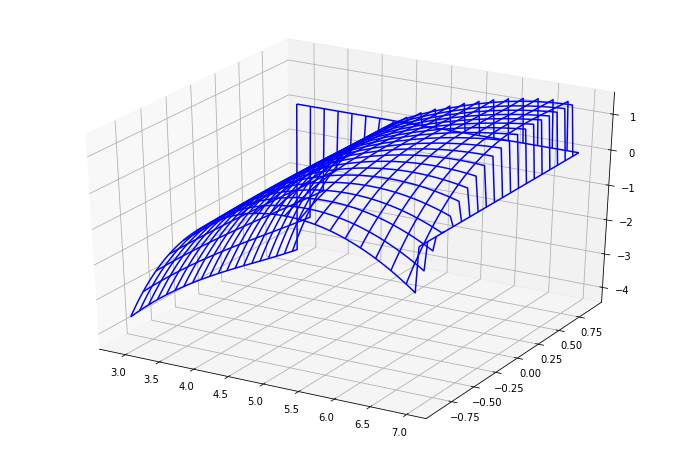

In [4]:
xx, yy = np.meshgrid(log10E, cosz)
xx=xx.T
yy=yy.T

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, output, rstride=5, cstride=5, color='blue')

## Sources

We can only precompute for a predefined set of redshifts and sky positions. Copy over what you do in the main code for now.

In [5]:
# Use a set of sources uniform in comoving volume for a lambda-CDM universe.
with h5py.File('../data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'].value
    position = f['output/position'].value
    
# Select sources within redshift zth to mimic catalogue
zth = 1
selection = np.where(redshift < zth)[0]

In [6]:
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
position = np.array([position[_] for _ in selection])

# Try ordering sources by redshift, as larger z => lower F
# This could help eliminate degeneracies in the mixture
inds = redshift.argsort()[::-1]
redshift = redshift[inds]
position = position[inds]
unit_vector = [p / np.linalg.norm(p) for p in position]

# Add background redshift
redshift = list(redshift) + [zth]

## Computation

For all the sources in the sample, produce a 1d grid to interpolate over

In [7]:
from scipy import integrate

In [8]:
def omega_to_cosz(omega):
    return np.cos(np.pi - np.arccos(omega[2]))

def integrand(E, spline, varpi, z, Emin, alpha):
    log10E = np.log10(E) # log10GeV
    cosz = omega_to_cosz(varpi)
    Aeff = 10**(spline(log10E, cosz)) # m^2
    return Aeff * ( ((1+z)*E) / Emin )**(-alpha)

def integrand_bg(E, cosz, spline, z, Emin, alpha):
    log10E = np.log10(E) # log10GeV
    Aeff = 10**(spline(log10E, cosz)) # m^2
    return Aeff * ( ((1+z)*E) / Emin )**(-alpha)

def get_eps(spline, varpi, z, Emin, alpha):
    integ, err = integrate.quad(integrand, Emin, np.inf, 
                                args=(spline, varpi, z, Emin, alpha))
    return integ

def get_eps_bg(spline, z, Emin, alpha):
    integ, err = integrate.dblquad(integrand_bg, -1, 1, 
                                   lambda x : Emin, lambda x : np.inf, 
                                   args=(spline, z, Emin, alpha))
    return integ

In [19]:
# Set up params
Emin = 1e4 # GeV, ie. 10 TeV
alpha = np.logspace(np.log(1.5), np.log(4), 100, base=np.e)
#alpha = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.25, 2.5, 2.75, 3.0, 4.0]

In [20]:
# Sources
eps = []
for varpi, z in zip(unit_vector, redshift):
    eps_k = []
    for a in alpha:
        eps_k.append(get_eps(spline, varpi, z, Emin, a))
    eps.append(eps_k)
# Background
eps_k = []
for a in alpha:
    eps_k.append(get_eps_bg(spline, z, Emin, a))
eps.append(eps_k)

/Users/fran/projects/bayes/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/Users/fran/projects/bayes/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/fran/projects

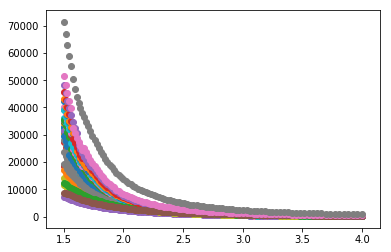

In [21]:
fig, ax = plt.subplots()
for eps_k in eps:
    ax.scatter(alpha, eps_k)

In [22]:
with h5py.File('precomputed_eps.h5', 'w') as f:
    f.create_dataset('alpha_grid', data=alpha)
    f.create_dataset('eps', data=eps)
    f.create_dataset('varpi', data=unit_vector)
    f.create_dataset('redshift', data=redshift)
    f.create_dataset('Emin', data=Emin)